# This NoteBook has implementation of EAST Alogorithm for text detection

## import the necessary packages

In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import glob


In [ ]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", type=str,
                help="path to input image")
ap.add_argument("-east", "--east", type=str,
                help="path to input EAST text detector")
ap.add_argument("-c", "--min-confidence", type=float, default=0.5,
                help="minimum probability required to inspect a region")
ap.add_argument("-w", "--width", type=int, default=320,
                help="resized image width (should be multiple of 32)")
ap.add_argument("-e", "--height", type=int, default=320,
                help="resized image height (should be multiple of 32)")
args = vars(ap.parse_args())


In [2]:
pdf_path = "C:/Users/Sanjeev/Documents/Python Scripts/NLP/Image_preprocessing/OneDrive_1_4-27-2020/*.pdf"
poppler_path = 'C:/python_lib/poppler-0.68.0/bin'
outfolder = "C:/Users/Sanjeev/Documents/Python Scripts/NLP/Image_preprocessing/output_image"
img_file_path = "C:/Users/Sanjeev/Documents/Python Scripts/NLP/Image_preprocessing/output_image/*.png"
# ptesseract_path ='C:/python_lib/ocr/tesseract.exe'
# data_path = "C:/Users/Sanjeev/Documents/Python Scripts/Dataset/df_word_list"
# pytesseract.pytesseract.tesseract_cmd = 'C:/python_lib/ocr/tesseract.exe'

## Function defination to display image 

In [3]:
def display_image_cv(img,window_name='None'):
    res = isinstance(img, str)
    if res:
        img = cv2.imread(img)
        
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.imshow(window_name, img)
#     cv2.waitkey(0)

def convert_pdf2image(pdf_path, output_path, poppler_path):
    file_path = glob.glob(pdf_path)
    img_list=[]
    for file in file_path:
        print(file)
        img_name= file.split("\\")[1]
        img_name = output_path+img_name.split(".")[0]+'.png'
        images = convert_from_path(file, 300, poppler_path=poppler_path)
        for image in images:
            image.save(img_name, 'PNG')
            img_list.append(images)
    
    return  img_list

def display_image(img,title='Image'):
    res = isinstance(img, str)
    if res:
        print('reading image ../n' )
        img = cv2.imread(img)  
    if len(img.shape) > 2:
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    else:
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')



## function to detect text in the image 

In [13]:
def get_detection(img_path,model_path,new_wh=(320,320)):
    # load the input image and grab the image dimensions
    # image = cv2.imread(args["image"])
    image = cv2.imread(img_path)      # image path 
    orig = image.copy()
    (H, W) = image.shape[:2]

    # set the new width and height and then determine the ratio in change
    # for both the width and height
    # (newW, newH) = (args["width"], args["height"])
    (newW, newH) = new_wh
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # define the two output layer names for the EAST detector model that
    # we are interested -- the first is the output probabilities and the
    # second can be used to derive the bounding box coordinates of text
    layerNames = [
        "feature_fusion/Conv_7/Sigmoid",
        "feature_fusion/concat_3"]

    # load the pre-trained EAST text detector
    print("[INFO] loading EAST text detector...")
    # net = cv2.dnn.readNet(args["east"])
    net = cv2.dnn.readNet(model_path) 
    
    
    
    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                                 (123.68, 116.78, 103.94), swapRB=True, crop=False)
    start = time.time()
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    end = time.time()

    # show timing information on text prediction
    print("[INFO] text detection took {:.6f} seconds".format(end - start))
    
    
    
    
    
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
    #         if scoresData[x] < args["min_confidence"]:
            if scoresData[x] < min_confidence:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
            
            
            
            
    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * rW)
        startY = int(startY * rH)
        endX = int(endX * rW)
        endY = int(endY * rH)

        # draw the bounding box on the image
        cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

    return orig

## path defination

In [4]:
img_path ="C:/Users/Sanjeev/Downloads/software/0325updated.task2train(626p)-20200414T125907Z-001/0325updated.task2train(626p)/X00016469612.jpg"
i =cv2.imread(img_path)
i.shape

(1013, 463, 3)

In [5]:
img_path_list =glob.glob("C:/Users/Sanjeev/Downloads/software/0325updated.task2train(626p)-20200414T125907Z-001/0325updated.task2train(626p)/*.jpg")
img_path_list[0]

'C:/Users/Sanjeev/Downloads/software/0325updated.task2train(626p)-20200414T125907Z-001/0325updated.task2train(626p)\\X00016469612.jpg'

## Test image path 

In [6]:
# img_path ="C:/Users/Sanjeev/Downloads/software/0325updated.task2train(626p)-20200414T125907Z-001/0325updated.task2train(626p)/X00016469612.jpg"
# img_path="C:/Users/Sanjeev/Documents/Python Scripts/Dataset/output/553155 10-14-19.png"
# img_path="C:/Users/Sanjeev/Documents/Python Scripts/NLP/car_wash.png"
img_path  ="C:/Users/Sanjeev/Downloads/software/0325updated.task2train(626p)-20200414T125907Z-001/0325updated.task2train(626p)/X00016469620.jpg"

## loading EAST Model from saved path 

In [7]:

model_path="C:/Users/Sanjeev/Documents/Python Scripts/NLP/frozen_east_text_detection.pb"
min_confidence=0.2

## perform detection on Image

In [14]:
# res=get_detection(img_path_list[0],model_path)
res = get_detection(img_path, model_path)

[INFO] loading EAST text detector...
[INFO] text detection took 0.712559 seconds


## displaying the result

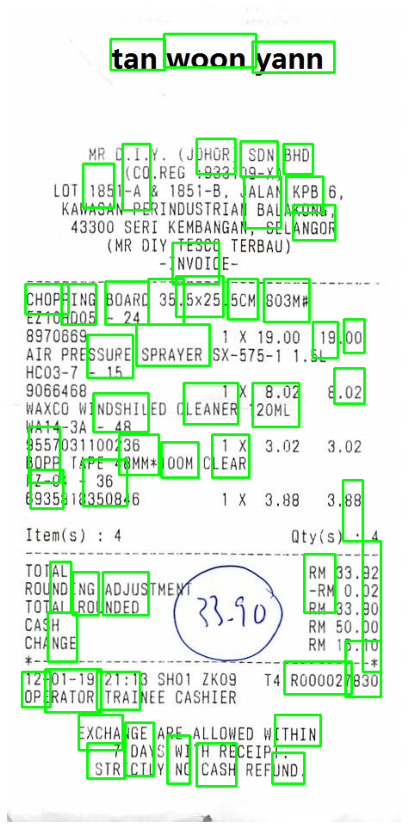

In [17]:
# display_image_cv(res)
# cv2.waitKey(0)

fig = plt.gcf()
fig.set_size_inches(25, 15)
plt.axis("off")
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.show()

## trying to improve the result

In [ ]:
# load the input image and grab the image dimensions
# image = cv2.imread(args["image"])
image = cv2.imread(img_path)      # image path 
orig = image.copy()
(H, W) = image.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height
# (newW, newH) = (args["width"], args["height"])
(newW, newH) = 320,320
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
# net = cv2.dnn.readNet(args["east"])
net = cv2.dnn.readNet(model_path) 

In [ ]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
                             (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

In [ ]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
#         if scoresData[x] < args["min_confidence"]:
        if scoresData[x] < min_confidence:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

In [ ]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
display_image_cv(orig,"Text Detection")
# display_image(orig,"Text Detection")
# cv2.imshow("Text Detection", orig)
cv2.waitKey(0)